In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import sys
import tensorflow as tf
from six.moves import cPickle as pickle
from __future__ import print_function
%matplotlib inline

In [3]:
type(mat['digitStruct']['name']), len(mat['digitStruct']['name'])

(h5py._hl.dataset.Dataset, 33402)

In [25]:
list_ = []
def getBoxes(data):
    if len(data) > 1:
        l = [mat[data[i].item()].value[0][0] for i in range(len(data))]
    else:
        l = [data.value[0][0]]
    return l
# for n in np.random.randint(0, 33000,size=10):
for n in [1]:
    attrs = {}
    bb = mat['digitStruct']['bbox'][n].item()
    h = mat[bb]['height']
    w = mat[bb]['width']
    l = mat[bb]['left']
    t = mat[bb]['top']
    label = [mat[mat[bb]['label'].value[0,0]].value[0,0], mat[mat[bb]['label'].value[1,0]].value[0,0]]
    
    attrs['label'] = label
    attrs['number'] = n
    attrs['height'] = getBoxes(h)
    attrs['width'] = getBoxes(w)
    attrs['left'] = getBoxes(l)
    attrs['top'] = getBoxes(t)
    list_.append(attrs)
# list_.sort(key=lambda e: e['number'])

In [26]:
list_

[{'height': [32.0, 32.0],
  'label': [2.0, 3.0],
  'left': [77.0, 98.0],
  'number': 1,
  'top': [29.0, 25.0],
  'width': [23.0, 26.0]}]

In [12]:
os.path?

In [2]:
class MatFile():
    def __init__(self, mat_name):
        import h5py
        self._file = h5py.File(mat_name)
        self.number_of_records = len(self._file['digitStruct']['name'])
        self.name = mat_name
        self.box_info = ('left', 'top', 'height', 'width')
        
    def getImgFileName(self, n):
        f_name = ''.join([chr(c) for c in self._file[self._file['digitStruct']['name'][n][0]].value])
        name = os.path.split(self.name)[0]+'/'+f_name
        
        return name


    def getBoxesAndLabels(self, n):
        ref = self._file['digitStruct']['bbox'][n].item()
        
        temp = self._file[ref]
        boxes = {elem: self.boxHelper(temp[elem]) for elem in self.box_info}
        
        # labels = []
        # label_len = len(boxes['left'])
        # for i in np.arange(label_len):
        #    label = self._file[self._file[ref]['label'].value[i,0]].value[0,0]
        #    labels.append(label)
        
        if len(boxes['left'])>1:
            labels = [self._file[self._file[ref]['label'].value[i,0]].value[0,0]
                      for i in np.arange(len(boxes['left']))]
        else:
            labels = [self._file[ref]['label'].value[0,0]]
            
        return boxes, labels
    
    
    
    def boxHelper(self, attr):
        if len(attr) > 1:
            l = [self._file[attr[i].item()].value[0][0] for i in range(len(attr))]
        else:
            l = [attr.value[0][0]]
        return l
    


In [3]:
mat = MatFile('train/digitStruct.mat')

In [4]:
n_img_file = 24434
im_name = mat.getImgFileName(n_img_file)
im_boxes, im_labels = mat.getBoxesAndLabels(n_img_file)
print(im_name, '\n', im_boxes, '\n', im_labels)
print(mat.number_of_records)

train/24435.png 
 {'width': [8.0], 'top': [7.0], 'height': [22.0], 'left': [41.0]} 
 [3.0]
33402


In [5]:
folders = ('train', 'test', 'extra')
train_info, test_info, extra_info={},{},{}
for folder in folders:
    counter = {2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
    mat = MatFile(folder+'/digitStruct.mat')
    for n in range(mat.number_of_records):
        _, labels = mat.getBoxesAndLabels(n)
        try:
            counter[len(labels)] += 1
        except KeyError:
            counter[len(labels)] = 1
    if folder == 'train':
        train_info = counter
    elif folder == 'test':
        test_info = counter
    else:
        extra_info = counter
print('train data counter:', train_info)
print('test data counter:', test_info)
print('extra data counter:', extra_info)

train data counter: {1: 5137, 2: 18130, 3: 8691, 4: 1434, 5: 9, 6: 1}
test data counter: {1: 2483, 2: 8356, 3: 2081, 4: 146, 5: 2, 6: 0}
extra data counter: {1: 9385, 2: 71726, 3: 106789, 4: 14338, 5: 115, 6: 0}


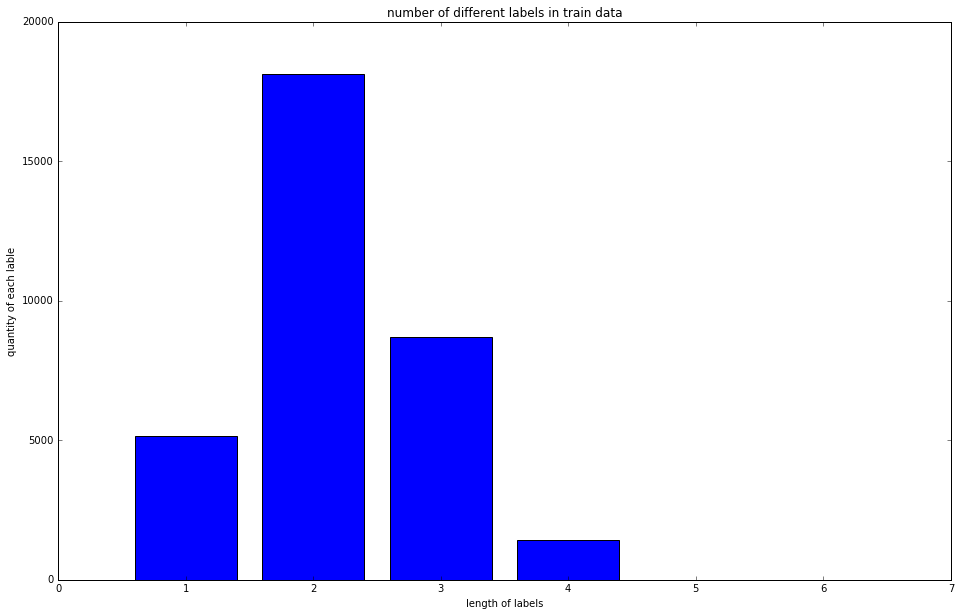

In [16]:
plt.figure(figsize=(16,10), dpi=75)
plt.bar(map(lambda n: n-0.4, train_info.keys()), train_info.values())
#plt.bar(map(lambda n: n-0.4, test_info.keys()), test_info.values())
#plt.bar(map(lambda n: n-0.4, extra_info.keys()), extra_info.values())
plt.title('number of different labels in train data')
# plt.legend(['expected net rewards'])
plt.xlabel('length of labels')
plt.ylabel('quantity of each lable')
plt.show()

In [3]:
def getTargetBox(boxes, img):
       
    left = np.amin(boxes['left'])
    top = np.amin(boxes['top'])
    width = np.amax(boxes['left']) + boxes['width'][np.argmax(boxes['left'])] - left
    height = np.amax(boxes['left']) + boxes['height'][np.argmax(boxes['left'])] - left
    
    left = int(np.floor(left - 0.1 * width))
    higher = int(np.floor(top - 0.1 * height))
    right = int(np.amin([np.ceil(left + 1.2 * width), img.size[0]]))
    lower = int(np.amin([np.ceil(top + 1.2 * height), img.size[1]]))
    
       
    return (left, higher, right, lower)

In [9]:
def generateData(mat):
    data = np.ndarray([mat.number_of_records, 32, 32, 1], dtype='float32')
    labels = np.ones([mat.number_of_records, 6], dtype='float32')*10
    for i in xrange(mat.number_of_records):
        if i%20000 == 0: print('The ', i, 'th file is in process! Be patient, please.')
        img = Image.open(mat.getImgFileName(i))
        
        boxes, labels_i = mat.getBoxesAndLabels(i)
        l = len(labels_i)
        labels[i, 0] = l
        if l-5 > 0:
            print('Picture ', i, ' has more than 5 digits.')
            l = 5
        for j in range(l): labels[i, j+1] = labels_i[j]
            
        target_box = getTargetBox(boxes, img)
        img = img.crop(target_box).resize([32,32], Image.ANTIALIAS)
        
        # Color to gray. 
        img = np.dot(np.array(img, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        
        # Global contrast normalization
        # mean = np.mean(img, dtype='float32')
        # std = np.std(img, dtype='float32', ddof=1)
        # if std - (1e-4) < 0: std = 1.
        # img = (img-mean)/std
        
        data[i,:,:,:] = img[:,:,:]
    print(mat.name, 'completed!')
    return data, labels

In [ ]:
folders = ('train',)# , 'test', 'extra')
X, y = {}, {}
for folder in folders:
    mat = MatFile(folder+'/digitStruct.mat')
    X[folder], y[folder] = generateData(mat)
    
X_train, y_train = generateData(mat)
print(X_train.shape, y_train.shape)

In [7]:
p = Image.fromarray(X_train[29929][:,:,0])
p.show()
print(y_train[29929])

[ 6.  1.  3.  5.  4.  5.]


In [8]:
X_train = np.delete(X_train, 29929, axis=0)
y_train = np.delete(y_train, 29929, axis=0)
print(X_train.shape, y_train.shape)

(33401, 32, 32, 1) (33401, 6)


In [10]:
folders = ('test', 'extra')
X, y = {}, {}
for folder in folders:
    mat = MatFile(folder+'/digitStruct.mat')
    X[folder], y[folder] = generateData(mat)

The  0 th file is in process! Be patient, please.
test/digitStruct.mat completed!
The  0 th file is in process! Be patient, please.
The  20000 th file is in process! Be patient, please.
The  40000 th file is in process! Be patient, please.
The  60000 th file is in process! Be patient, please.
The  80000 th file is in process! Be patient, please.
The  100000 th file is in process! Be patient, please.
The  120000 th file is in process! Be patient, please.
The  140000 th file is in process! Be patient, please.
The  160000 th file is in process! Be patient, please.
The  180000 th file is in process! Be patient, please.
The  200000 th file is in process! Be patient, please.
extra/digitStruct.mat completed!


In [12]:
X_extra, y_extra = X['extra'], y['extra']
X_test, y_test = X['test'], y['test']
print(X_extra.shape, y_extra.shape)
print(X_test.shape, y_test.shape)

(202353, 32, 32, 1) (202353, 6)
(13068, 32, 32, 1) (13068, 6)


In [13]:
X_extra, X_valid = np.split(X_extra, [-2000])
print(X_extra.shape, X_valid.shape)

(200353, 32, 32, 1) (2000, 32, 32, 1)


In [14]:
X_train = np.concatenate((X_train, X_extra))
print(X_train.shape)

(233754, 32, 32, 1)


In [15]:
y_extra, y_valid = np.split(y_extra, [-2000])
y_train = np.concatenate((y_train, y_extra))

In [16]:
print(y_train.shape)

(233754, 6)


In [17]:
def shuffleDataAndLabels(X, y):
    random_state = np.random.get_state()
    np.random.shuffle(X)
    np.random.set_state(random_state)
    np.random.shuffle(y)

In [18]:
# scramble the original train and extra data
shuffleDataAndLabels(X_train, y_train)
shuffleDataAndLabels(X_train, y_train)

In [51]:
rand = np.random.randint(0, 229754, size=3)
rand

array([123179, 196734, 213837])

In [55]:
for a in rand:
    print(y_train[a])

[  2.   2.   1.  10.  10.  10.]
[  1.   2.  10.  10.  10.  10.]
[  2.   1.   9.  10.  10.  10.]


In [56]:
for n in rand:
    p = Image.fromarray(X_train[n][:,:,0])
    p.show()

In [19]:
pickle_file = 'SVHN'

try:
    with open(pickle_file, 'wb') as write_file:
        content_to_save = {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'X_valid': X_valid,
            'y_valid': y_valid
            }
        pickle.dump(content_to_save, write_file, pickle.HIGHEST_PROTOCOL)

except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1025147028


In [20]:
def sampleDataAndLabels(datas, labels, n_samples):
    idx = np.arange(len(labels))
    # perm = np.random.permutation(idx)
    # sample_datas = datas[perm]
    # sample_labels = labels[perm]
    # random_state = np.random.get_state()
    sample_idx = np.random.choice(idx, size=n_samples, replace=False)
    sample_datas = datas[sample_idx]
    sample_labels = labels[sample_idx]
    # np.random.set_state(random_state)
    #sample_labels = np.random.choice(labels, size=n_samples, replace=False)
    
    return sample_datas, sample_labels

In [16]:
single_point.shape

(1, 32, 32, 1)

In [19]:
single_point, single_label, n = sampleDataAndLabels(X_valid, y_valid, 1)
p = Image.fromarray(single_point[0,:,:,0])
p.show()
print(single_label)
print('position is', n)

[[  3.   8.  10.   8.  10.  10.]]
position is [1685]


In [4]:
pickle_file2 = 'toy_data.pickle'

toy_train_size, toy_test_size, toy_valid_size = 10000, 1000, 800

toy_X_train, toy_y_train = sampleDataAndLabels(X_train, y_train, toy_train_size)
toy_X_test, toy_y_test = sampleDataAndLabels(X_test, y_test, toy_test_size)
toy_X_valid, toy_y_valid = sampleDataAndLabels(X_valid, y_valid, toy_valid_size)


try:
    with open(pickle_file2, 'wb') as writeFile:
        content_to_save = {
            'toy_X_train': toy_X_train,
            'toy_y_train': toy_y_train,
            'toy_X_test': toy_X_test,
            'toy_y_test': toy_y_test,
            'toy_X_valid': toy_X_valid,
            'toy_y_valid': toy_y_valid
            }
        pickle.dump(content_to_save, writeFile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Failed save data to', pickle_file2, ':', e)
    raise

In [23]:
os.listdir('./')

['talking_data',
 'test',
 'test.tar.gz',
 'conv_net.ipynb',
 'data_preprocess.ipynb',
 'train',
 'toy_data.pickle',
 'extra',
 'train.tar.gz',
 '.ipynb_checkpoints',
 'SVHN.pickle',
 'single_digit',
 'extra.tar.gz',
 'example.ipynb']

In [28]:
for i in range(0, 2):
    print(map(chr, mat[mat['digitStruct']['name'][i][0]].value))

['1', '.', 'p', 'n', 'g']
['2', '.', 'p', 'n', 'g']


In [5]:
mat[mat[mat['digitStruct']['bbox'][901].item()]['height'].value[0].item()].value

array([[ 37.]])

In [36]:
len(mat['digitStruct']['bbox']), len(mat['digitStruct']['name'])

(33402, 33402)

In [51]:
print_mat_nested(mat_f, 1, 2)

	Key: #refs#
	Key: digitStruct


In [46]:
import scipy.io as sio
data_test = sio.loadmat('test_32x32.mat')
type(data_test)

dict

In [55]:
data_test['X'].shape

(32, 32, 3, 26032)

In [57]:
data_test['X'][0,0,0]

array([ 38, 129, 150, ..., 115,  96, 101], dtype=uint8)